In [1]:
from e3fp.fingerprint.fprint import Fingerprint
from e3fp.fingerprint.fprint import CountFingerprint
from e3fp.fingerprint.db import FingerprintDatabase
from e3fp.fingerprint.metrics.array_metrics import tanimoto
import matplotlib.pyplot as pyplot
import numpy as np
import pandas as pd
import pickle
from scipy.sparse import csr_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import torch
import torch.nn as nn

In [2]:
logP = pickle.load(open("chem_df.p", "rb"))

In [3]:
scaler = StandardScaler()
y = scaler.fit_transform(logP.logp.values.reshape(-1, 1))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(logP['fingerprint'], y, test_size=0.2, random_state=42)

In [5]:
X_train_db = FingerprintDatabase(fp_type=Fingerprint, name="X_train")
X_train_db.add_fingerprints(X_train.values)
X_train_db_fold = X_train_db.fold(1024)

X_test_db = FingerprintDatabase(fp_type=Fingerprint, name="X_test")
X_test_db.add_fingerprints(X_test.values)
X_test_db_fold = X_test_db.fold(1024)

In [6]:
X_train_torch = torch.tensor(X_train_db_fold.array.toarray()).float()
X_test_torch = torch.tensor(X_test_db_fold.array.toarray()).float()
X_train_torch

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

In [7]:
y_train

array([[-0.33797329],
       [-0.52433143],
       [ 0.11461078],
       ...,
       [-1.6158577 ],
       [ 0.14123337],
       [ 0.27434633]])

In [8]:
y_train_torch = torch.tensor(y_train).float()
y_test_torch = torch.tensor(y_test).float()
y_train_torch

tensor([[-0.3380],
        [-0.5243],
        [ 0.1146],
        ...,
        [-1.6159],
        [ 0.1412],
        [ 0.2743]])

In [9]:
X_train_torch.shape

torch.Size([32354, 1024])

In [10]:
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=256, shuffle=True)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [12]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, out_size)
        self.ln1 = nn.LayerNorm(hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.ln3 = nn.LayerNorm(hidden_size)
        
        self.activation = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout_rate)
    def forward(self, x):
        out = self.fc1(x)
        out = self.ln1(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.ln2(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.ln3(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc_out(out)
        return out

In [13]:
input_size = X_train_torch.size()[-1]
hidden_size = 1024
dropout_rate = 0.80
output_size = 1
learning_rate = 0.001
model = Net(input_size, hidden_size, dropout_rate, output_size)

In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
model.train()
epochs = 200
for e in range(epochs):
    running_loss = 0
    for fps, lp in train_loader:
        optimizer.zero_grad()
        pred = model(fps)
        loss = criterion(pred, lp)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if e % 10 == 0:
        print('epoch: %d  loss: %f' % (e, running_loss/len(train_loader)))

epoch: 0  loss: 0.580963
epoch: 10  loss: 0.158202
epoch: 20  loss: 0.131945
epoch: 30  loss: 0.118820
epoch: 40  loss: 0.109606
epoch: 50  loss: 0.103419
epoch: 60  loss: 0.097397
epoch: 70  loss: 0.092383
epoch: 80  loss: 0.090240
epoch: 90  loss: 0.087864
epoch: 100  loss: 0.082731
epoch: 110  loss: 0.081845
epoch: 120  loss: 0.081643
epoch: 130  loss: 0.077079
epoch: 140  loss: 0.076976
epoch: 150  loss: 0.076352
epoch: 160  loss: 0.073457
epoch: 170  loss: 0.072051
epoch: 180  loss: 0.072609
epoch: 190  loss: 0.071767


In [23]:
def flatten(tensor):
    return tensor.cpu().detach().numpy().flatten()

In [24]:
model.eval()
y_pred_train = model(X_train_torch)
y_pred_test = model(X_test_torch)

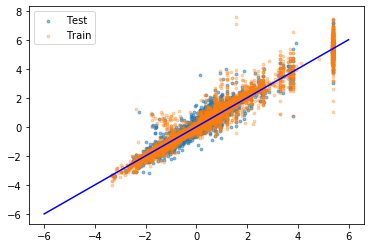

In [25]:
pyplot.scatter(flatten(y_pred_test), flatten(y_test_torch), alpha=0.5, s=8, label="Test")
pyplot.scatter(flatten(y_pred_train), flatten(y_train_torch), alpha=0.3, s=8, label="Train")
pyplot.legend()
pyplot.plot([-6, 6],[-6, 6],c="b")

In [26]:
with open('nn.p', mode='wb') as file:
    pickle.dump(model, file)

In [27]:
db = FingerprintDatabase(fp_type=Fingerprint, name="logp")
db.add_fingerprints(logP.fingerprint)
db_fold = db.fold(1024)

In [28]:
X_tensor = torch.tensor(db_fold.array.toarray()).float()
logP['nn_logp'] = scaler.inverse_transform(model(X_tensor).cpu().detach().numpy())

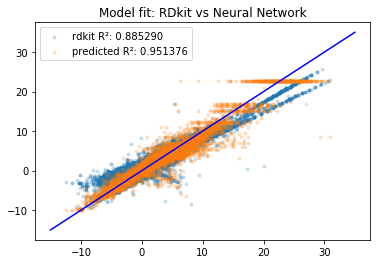

In [30]:
r2 = r2_score(logP['logp'], logP['rdkit_logp'])
pyplot.scatter(logP['logp'], logP['rdkit_logp'], alpha=0.2, s=8, label='rdkit R²: %f' % r2)

r2 = r2_score(logP['logp'], logP['nn_logp'])
pyplot.scatter(logP['logp'], logP['nn_logp'], alpha=0.2, s=8, label='predicted R²: %f' % r2)
pyplot.title('Model fit: RDkit vs Neural Network')
pyplot.legend()
pyplot.plot([-15, 35], [-15, 35], c="b")
pyplot.show()

Conclusion: The model performs very well.

In [31]:
clf = pickle.load(open("svr.p", "rb"))

In [32]:
logP['svr_logp'] = clf.predict(db_fold.array)

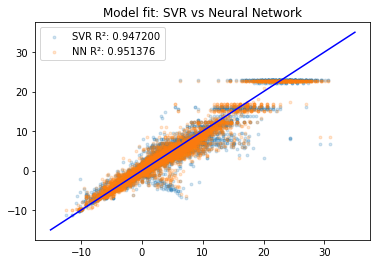

In [33]:
r2 = r2_score(logP['logp'], logP['svr_logp'])
pyplot.scatter(logP['logp'], logP['svr_logp'], alpha=0.2, s=8, label='SVR R²: %f' % r2)

r2 = r2_score(logP['logp'], logP['nn_logp'])
pyplot.scatter(logP['logp'], logP['nn_logp'], alpha=0.2, s=8, label='NN R²: %f' % r2)
pyplot.title('Model fit: SVR vs Neural Network')
pyplot.legend()
pyplot.plot([-15, 35], [-15, 35], c="b")
pyplot.show()

attempting more training epochs to see if fit will improve without creating too much overfit

In [34]:
model.train()
epochs = 100
for e in range(epochs):
    running_loss = 0
    for fps, lp in train_loader:
        optimizer.zero_grad()
        pred = model(fps)
        loss = criterion(pred, lp)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if e % 10 == 0:
        print('epoch: %d  loss: %f' % (e, running_loss/len(train_loader)))

epoch: 0  loss: 0.069184
epoch: 10  loss: 0.068700
epoch: 20  loss: 0.068280
epoch: 30  loss: 0.068394
epoch: 40  loss: 0.065684
epoch: 50  loss: 0.066706
epoch: 60  loss: 0.065898
epoch: 70  loss: 0.064478
epoch: 80  loss: 0.063549
epoch: 90  loss: 0.065364


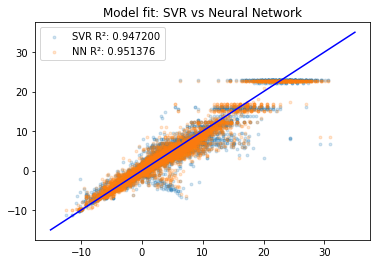

In [36]:
model.eval()
r2 = r2_score(logP['logp'], logP['svr_logp'])
pyplot.scatter(logP['logp'], logP['svr_logp'], alpha=0.2, s=8, label='SVR R²: %f' % r2)

r2 = r2_score(logP['logp'], logP['nn_logp'])
pyplot.scatter(logP['logp'], logP['nn_logp'], alpha=0.2, s=8, label='NN R²: %f' % r2)
pyplot.title('Model fit: SVR vs Neural Network')
pyplot.legend()
pyplot.plot([-15, 35], [-15, 35], c="b")
pyplot.show()

In [37]:
logP['qsar_logp'] = scaler.inverse_transform(model(X_tensor).cpu().detach().numpy())

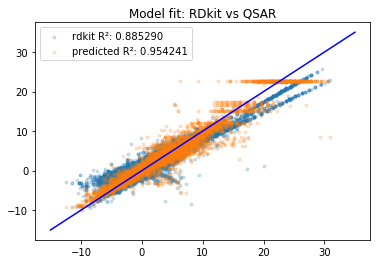

In [39]:
r2 = r2_score(logP['logp'], logP['rdkit_logp'])
pyplot.scatter(logP['logp'], logP['rdkit_logp'], alpha=0.2, s=8, label='rdkit R²: %f' % r2)

r2 = r2_score(logP['logp'], logP['qsar_logp'])
pyplot.scatter(logP['logp'], logP['qsar_logp'], alpha=0.2, s=8, label='predicted R²: %f' % r2)
pyplot.title('Model fit: RDkit vs QSAR')
pyplot.legend()
pyplot.plot([-15, 35], [-15, 35], c="b")
pyplot.show()

In [40]:
with open('nn.p', mode='wb') as file:
    pickle.dump(model, file)

the extra training increased the R² from 95.13% to 95.42%. While this is a fairly minor increase, it does now surpass the fit of the SVR model.